# <center> Kaggle Data Competition Report </center>
<center> Cathy Jia </center>
<center> June 5, 2019 </center>

In [1]:
# Display all of the results.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

# import packages
import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.linear_model import LogisticRegressionCV
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC

# import my written modules
from prepare import stdData, subsetData
from fast_gradient import initEta, fastgradalgo, ME_plot

## I. Load ImageNet Dataset
The very first step is to download the dataset file and convert each image into a feature vector using the provided extract features.py script. Then I loaded train set, validation set and test set.

In [2]:
# Load data
x_train = np.load('train_features.npy')
y_train = np.load('train_labels.npy')
x_val = np.load('val_features.npy')
y_val = np.load('val_labels.npy')
x_test = np.load('test_features.npy')

print('Training set')
print('Number of observations: %d' % x_train.shape[0])
print('Number of dimension: %d' % x_train.shape[1])
print('\nValidation set')
print('Number of observations: %d' % x_val.shape[0])
print('Number of dimension: %d' % x_val.shape[1])

Training set
Number of observations: 50000
Number of dimension: 4096

Validation set
Number of observations: 10000
Number of dimension: 4096


## II. Write Modules

I wrote three modules for the Kaggle data competition, with the following functions:

- `prepare.py`
    - stdData - Standardize data
    - subsetData - Subset data  
- `fast_gradient.py`
    - obj - Compute objective value
    - computegrad - Compute gradient
    - backtracking - Apply backtracking rule to update eta value
    - initEta - Get initialized eta value
    - fastgradalgo - Apply fast gradient descent to find beta values
    - predict - Make prediction with an individual classifier
    - computeME - Compute misclassification error
    - ME_plot - Make misclassification error plot
    - multiPredict - Make prediction for multi class
- `svm.py`
    - kernel_linear - Compute linear kernel
    - obj - Compute objective value
    - computegrad - Compute gradient
    - backtracking - Apply backtracking rule to update eta value
    - initEta - Get initialized eta value
    - mysvm - Apply fast gradient descent to find beta values for given kernel
    - predict - Make prediction with an individual classifier
    - multiPredict - Make prediction for multi class
    
These functions are collected from homework assignment and updated with improvements.

## III. Fast Gradient Algorithm

At this step, I started with training $l_2$-regularized logistic regression classifier and make prediction for test set with fast gradient algorithm. I used my own fast gradient algorithm function to train classifiers.

### HW6 Answer
- **Pick two classes of your choice from the dataset. Train an  $l_2$-regularized logistic regression classifier on the training set using your own fast gradient algorithm with $\lambda = 1$. Plot, with different colors, the misclassification error on the training set and on the validation set vs iterations.**

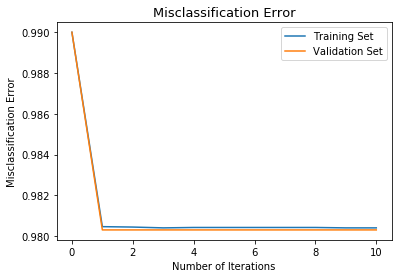

In [3]:
# Choose class 0 and 1
# Subset data
xtrain, ytrain = subsetData(x_train, y_train, 0, 1)

# Run fast gradient algorithm
beta_theta_init = np.zeros([xtrain.shape[1],])
lamb = 1
eta_init = initEta(xtrain, lamb)
X = xtrain
Y = ytrain

# Run fast gradient algorithm
vals_fg = fastgradalgo(beta_theta_init, eta_init, X, Y, lamb)

# Plot misclassification error
ME_plot(x_train, y_train, x_val, y_val, vals_fg, 0, 1)

According to this misclassification error plot, we can see that the misclassification errors for both training set and validation set are decreased to around 98%. This indicates that the fast gradient algorithm performed well to train a classifier to almost accurately classify the selected two classes, 0 and 1.

- **Find the value of the regularization parameter $\lambda$ using cross-validation; you may use scikit-learn’s built-in functions for this purpose. Train an $l_2$-regularized logistic regression classifier on the training set using your own fast gradient algorithm with that value of $\lambda$ found by cross-validation. Plot, with different colors, the misclassification error on the training set and on the validation set vs iterations.**

The optimal lambda is 0.0000167991


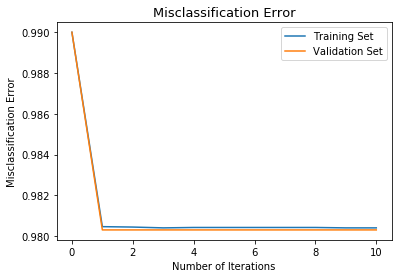

In [4]:
# Find optimal regularization parameter lamb_opt
clf = LogisticRegressionCV(Cs=20).fit(xtrain, ytrain)
n = xtrain.shape[0]
lamb_opt = 1/ (2 * n * clf.C_)
print('The optimal lambda is %.10f' % lamb_opt)

# Run fast gradient algorithm
vals_fg = fastgradalgo(beta_theta_init, eta_init, X, Y, lamb)

# Plot misclassification error
ME_plot(x_train, y_train, x_val, y_val, vals_fg, 0, 1)

In this step, I used `LogisticsRegressionCV` to find the optimal regularization parameter $\lambda$. Similarly, according to this misclassification error plot, we can see that the misclassification errors for both training set and validation set are decreased to around 98%. This indicates that the fast gradient algorithm performed well to train a classifier to almost accurately classify the selected two classes, 0 and 1.

### Predict Test Data

Then I moved on to predict test data by train classifiers using my own fast gradient algorithm. This was done in both one-vs-one and one-vs-rest. I run my python code on AWS. Once the prediction is finished, I saved the prediction result named `pred` into submission file, using the following code:

```python
# Write to submission.csv
df = pd.read_csv('sample_submission.csv')
df['Category'] = pred
df.to_csv('submission.csv', index=False)
```

**1. One-vs-One**

`python3 run_fast_gradient_ovo.py`

- Partial code

```python
# Train OvO classifiers
arr = [i for i in range(100)]
pairs = list(combinations(arr, 2))
clfs = []

n, d = x_train.shape
beta_theta_init = np.zeros([4096,])
lamb = 1

for pair in pairs:
    class1 = pair[0]
    class2 = pair[1]
    xtrain, ytrain = subsetData(x_train, y_train, class1, class2, ovo=True)
    eta = initEta(xtrain, lamb)
    vals_fg = fastgradalgo(beta_theta_init, eta_init, X, Y, lamb)
    clf = vals_fg[-1:].reshape(-1)
    clfs.append(clf)

# Test set
pred = multiPredict(x_test, pairs, clfs, ovo=True)
```
- Explanation

I select $\lambda = 1$ in this case. For each pair/combination of the list of class label form 0 through 100, I subset the data of this pair of classes and run my fast gradient algorithm `fastgradalgo` to train a classifier, which was stored in the classifiers set named `clfs`. In one-vs-one prediction, we predict for the data points by the most frequently predicted class. I have setup this rule in the function `multiPredict`.

**2. One-vs-Rest**

`python3 run_fast_gradient_ovr.py`

- Partial code

```python
# Train OvR classifiers
arr = [i for i in range(1)]
pairs = []
clfs = []

n, d = x_train.shape
beta_theta_init = np.zeros([4096,])
lamb = 1
std_x_train = stdData(x_train)
eta_init = initEta(std_x_train, lamb)

for cls in arr:
    pairs.append([cls, -1])
    xtrain, ytrain = subsetData(x_train, y_train, cls, -1, ovo=False)
    vals_fg = fastgradalgo(beta_theta_init, eta_init, X, Y, lamb)
    clf = betas[-1:].reshape(-1)
    clfs.append(clf)

# Test set
pred = multiPredict(x_test, pairs, clfs, ovo=False)
```
- Explanation

I select $\lambda = 1$ in this case. For each class of the list of class label from 0 through 100, I subset the data by keep this class label and temporarily change the rest class label to -1. Then I run my fast gradient algorithm `fastgradalgo` to train a classifier, which was stored in the classifiers set named `clfs`. To accelerate the classifier training, I put the computation for initial $\eta$ out of the for loop. In one-vs-rest prediction, I choose to predict for the data points by the predicted class with highest magnitude in order to avoid label -1. I have setup this rule in the function `multiPredict`.

## IV. Linear SVM

Here we make prediction by training a linear SVM classifier. I attempted to use both sklearn built-in function LinearSVC and my own svm function to train linear SVM classifiers.

### HW7 Answer
- **In a one-vs-one fashion, for each pair of classes, train a linear SVM classifier using scikit-learn’s function LinearSVC, with the default value for the regularization parameter. Compute the multi-class misclassification error obtained using these classifiers trained in a one-vs-one fashion.**

In [5]:
# Train a linear SVM classifier in OVO
svm = LinearSVC()
clf = OneVsOneClassifier(svm, n_jobs=-1)
clf.fit(x_train,y_train)

# Validation set
score = clf.score(x_val, y_val)
error = 1 - score
print('Multi-class misclassification error on validation set is %.2f' % error)

OneVsOneClassifier(estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
          n_jobs=-1)

Multi-class misclassification error on validation set is 0.48


- **In a one-vs-rest fashion, for each class, train a linear SVM classifier using scikit-learn’s function LinearSVC, with the default value for $\lambda c$. Compute the multi-class misclassification error obtained using these classifiers trained in a one-vs-rest fashion.**

In [6]:
# Train OvR classifiers
clf = LinearSVC(multi_class='ovr')
clf.fit(x_train, y_train)

# Validation set
score = clf.score(x_val, y_val)
error = 1 - score
print('Multi-class misclassification error on validation set is %.2f' % error)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

Multi-class misclassification error on validation set is 0.55


### Predict Test Data

To predict test data, I trie to use my own function for train linear SVM classifiers to make prediction. This was done in both one-vs-one and one-vs-rest. I run my python code on AWS. Once the prediction is finished, I saved the prediction result named `pred` into submission file, using the following code:

```python
# Write to submission.csv
df = pd.read_csv('sample_submission.csv')
df['Category'] = pred
df.to_csv('submission.csv', index=False)
```

**1. One-vs-One**

`python3 run_svm_ovo.py`

- Partial code

```python
# Train OvO classifiers
arr = [i for i in range(100)]
pairs = list(combinations(arr, 2))
clfs = []

# Train SVM with linear kernel
lamb = 1

for pair in pairs:
    class1 = pair[0]
    class2 = pair[1]
    xtrain, ytrain = subsetData(x_train, y_train, class1, class2, ovo=True)
    n, d = xtrain.shape
    k = kernel_linear(xtrain)
    eta = initEta(k, lamb)
    betas = mysvm(np.zeros(n), eta, k, ytrain, lamb)
    clf = betas[-1:].reshape(-1)
    clfs.append(clf)

# Test set
pred = multiPredict(x_test, pairs, clfs, ovo=True)
```
- Explanation

I select $\lambda = 1$ in this case. For each pair/combination of the list of class label form 0 through 100, I subset the data of this pair of classes, compute linear kernel and use my fast gradient algorith `mysvm` to train a linear SVM classifier, which was stored in the classifiers set named `clfs`. In one-vs-one prediction, we predict for the data points by the most frequently predicted class. I have setup this rule in the function `multiPredict`.

**2. One-vs-Rest**

`python3 run_svm_ovr.py`

- Partial code

```python
# Train OvR classifiers
arr = [i for i in range(100)]
pairs = []
clfs = []

# Train SVM with linear kernel
std_x_train = stdData(x_train)
K = kernel_linear(std_x_train)
lamb = 1
eta = initEta(K, lamb)

for cls in arr:
    pairs.append([cls, -1])
    xtrain, ytrain = subsetData(x_train, y_train, cls, -1, ovo=False)
    n, d = xtrain.shape
    betas = mysvm(np.zeros(n), eta, K, ytrain, lamb)
    clf = betas[-1:].reshape(-1)
    clfs.append(clf)

# Test set
pred = multiPredict(x_test, pairs, clfs, ovo=False)
```
- Explanation

I select $\lambda = 1$ in this case. For each class of the list of class label from 0 through 100, I subset the data by keep this class label and temporarily change the rest class label to -1. Then I run my fast gradient algorithm `mysvm` to train a linear SVM classifier, which was stored in the classifiers set named `clfs`. To accelerate the classifier training, I put the computation for initial $\eta$ out of the for loop. Since the linear kernel should be the same for each class subset, I also took the computation for linear kernel out of the for loop. In one-vs-rest prediction, I choose to predict for the data points by the predicted class with highest magnitude in order to avoid label -1. I setup this rule in the function `multiPredict`. 

## V. Sklearn Built-In Function

Besides, I also tried to train classifiers using sklearn built-in function.

### Predict Test Data
I predict the test data in both one-vs-one and one-vs-rest. I run my python code on AWS. Once the prediction is finished, I saved the prediction result named `pred` into submission file, using the following code:

```python
# Write to submission.csv
df = pd.read_csv('sample_submission.csv')
df['Category'] = pred
df.to_csv('submission.csv', index=False)
```

**1. LogisticRegressionCV with multinomial**

`python3 run_sklearn_multinomial.py`

- Partial Code

```python
clf = LogisticRegressionCV(multi_class='multinomial')
clf.fit(x_train, y_train)

# Test set
pred = clf.predict(x_test)
```

- Explanation

I use sklearn built-in function `LogisticRegressionCV` with multi_class being multinomial here. The value of $\lambda$ will be computed using cross validation. The test data is predicted by the predict method.

**2. LogisticRegressionCV with ovr**

`python3 run_sklearn_ovr.py`

- Partial Code

```python
clf = LogisticRegressionCV(multi_class='ovr')
clf.fit(x_train, y_train)

# Test set
pred = clf.predict(x_test)
```

- Explanation

I use sklearn built-in function `LogisticRegressionCV` with multi_class being ovr, i.e., one-vs-rest here. The value of $\lambda$ is computed using cross validation. The test data is predicted by the predict method.

## VI. Results and Findings

I run all my classifier training and data prediction on AWS E2 using p3.2xlarge instance. I got a highest score of 0.54900 on Kaggle leaderboard, which took 30% of my prediction result. This indicates that my best classifier only gives 54.90% accuracy in predicting the 30% test data.

One thing I found was that one-vs-one performs better than one-vs-rest, but has a trade-off in time cost.

Training a classifier for 50000 training set and making prediction for 10000 test data is time-consumed, even on AWS. There are many matrix multiplication which cost long runtime for a large number of data points. The sklearn built-in functions took less time than my own functions. It took me almost half day to train $l_2$-regularized logistic regression classifiers in both one-vs-one fashion and one-vs-rest fashion using the sklearn built-in `LogisticRegressionCV`. It took me two hours to train linear SVM classifiers in both one-vs-one fashion and one-vs-rest fashion using the sklearn built-in `LinearSVC`.

I noticed that the one-vs-one fashion especially took long time when I trained classifiers using $l_2$-regularized logistic regression and linear SVM. When I did model training in one-vs-one fashion, there are 4950 pairs of classes. So for each pair, we need to apply fast gradient descent algorithm with some iterations, including backtracking with some iterations. Overall, one-vs-one took so many iterations. I was able to train $l_2$-regularized logistic regression classifiers by my own function for a whole day. I failed to train linear SVM classifiers using my own function because it didn't cost reasonable amoung of time, although I tried to tune the parameters.

Moreover, I opened some of the training images and observed that some of the animal folders have mixed animals. For example, there is a rooster among many small grey birds. Also, some animal images have confusing factors that may reduce the training classification accuracy. For instance, a man holding a fish, a chameleon hidding in green plants, a shark in the sea. These kind of images may be extracted with inaccurate features.

## VII. Challenge and Improvement

One of the challenges in this data competition project was the extremely long training time. Especially for training in one-vs-one fashion, there are a large amount of data with 100 classes. Although I tried to tune the regularization parameter and maximum iteration limit, it still took me very long time to train classifiers for one-vs-one case. I failed to train classifiers in reasonable amount of time for one-vs-one, but the one-vs-rest case enable me to get some results.

Another limitation of my code is the one-vs-rest prediction. In one-vs-one prediction, we predict for the data points by the most frequently predicted class. However, in one-vs-rest prediction, I am not sure about the rule. I chose to predict for the data points by the highest magnitude of predicted class, in order to avoid -1 temporary label. This may affect the accuracy of the prediction.

Therefore, as improvement, I need to accelerate my training iterations by tuning parameters, and optimizing the computing and storage. Also, I need to increase the prediction accuracy by checking functional correctness and update one-vs-rest prediction rule.